In [1]:
from decouple import config
import pandas as pd
import pandas_ta as ta
from deap import gp

from Ionomy import IonPanda, BitTA
from GPrules import DemiChad

In [2]:
# MARKET = 'usd-btc'
# CURRENCY = 'btc'
# BASE = 'usd'
# TIME = 'hour'
# LIMIT = 10_000

In [3]:
# bta = BitTA(config('TREX_KEY'), config('TREX_SECRET'))
# ionpd = IonPanda(config('IONOMY_KEY'), config('IONOMY_SECRET'))
# bta.update(CURRENCY, BASE, TIME, LIMIT)
# df = bta.df
# df.to_csv('./btc-usd.csv', index=False)

In [4]:
df = pd.read_csv('./btc-usd.csv')

In [5]:
df

,time,close,high,low,open,volumebtc,volume,date
0,1559444400,8567.93,8577.53,8562.11,8573.88,6.238,53454.39,2019-06-02
1,1559448000,8585.00,8585.00,8563.11,8567.93,4.779,40979.54,2019-06-02
2,1559451600,8600.00,8600.00,8569.15,8585.00,6.016,51642.36,2019-06-02
3,1559455200,8598.50,8609.13,8575.68,8600.00,6.747,57975.52,2019-06-02
4,1559458800,8715.95,8740.00,8598.20,8598.50,33.800,293431.23,2019-06-02
...,...,...,...,...,...,...,...,...
9996,1595415600,9349.96,9357.21,9336.97,9342.73,2.823,26384.62,2020-07-22
9997,1595419200,9339.80,9350.61,9321.28,9349.96,12.890,120351.51,2020-07-22
9998,1595422800,9335.99,9346.27,9333.63,9339.80,14.460,135079.43,2020-07-22
9999,1595426400,9346.38,9346.38,9321.60,9335.99,22.210,207325.28,2020-07-22


In [6]:
%%capture
demichad = DemiChad(df)

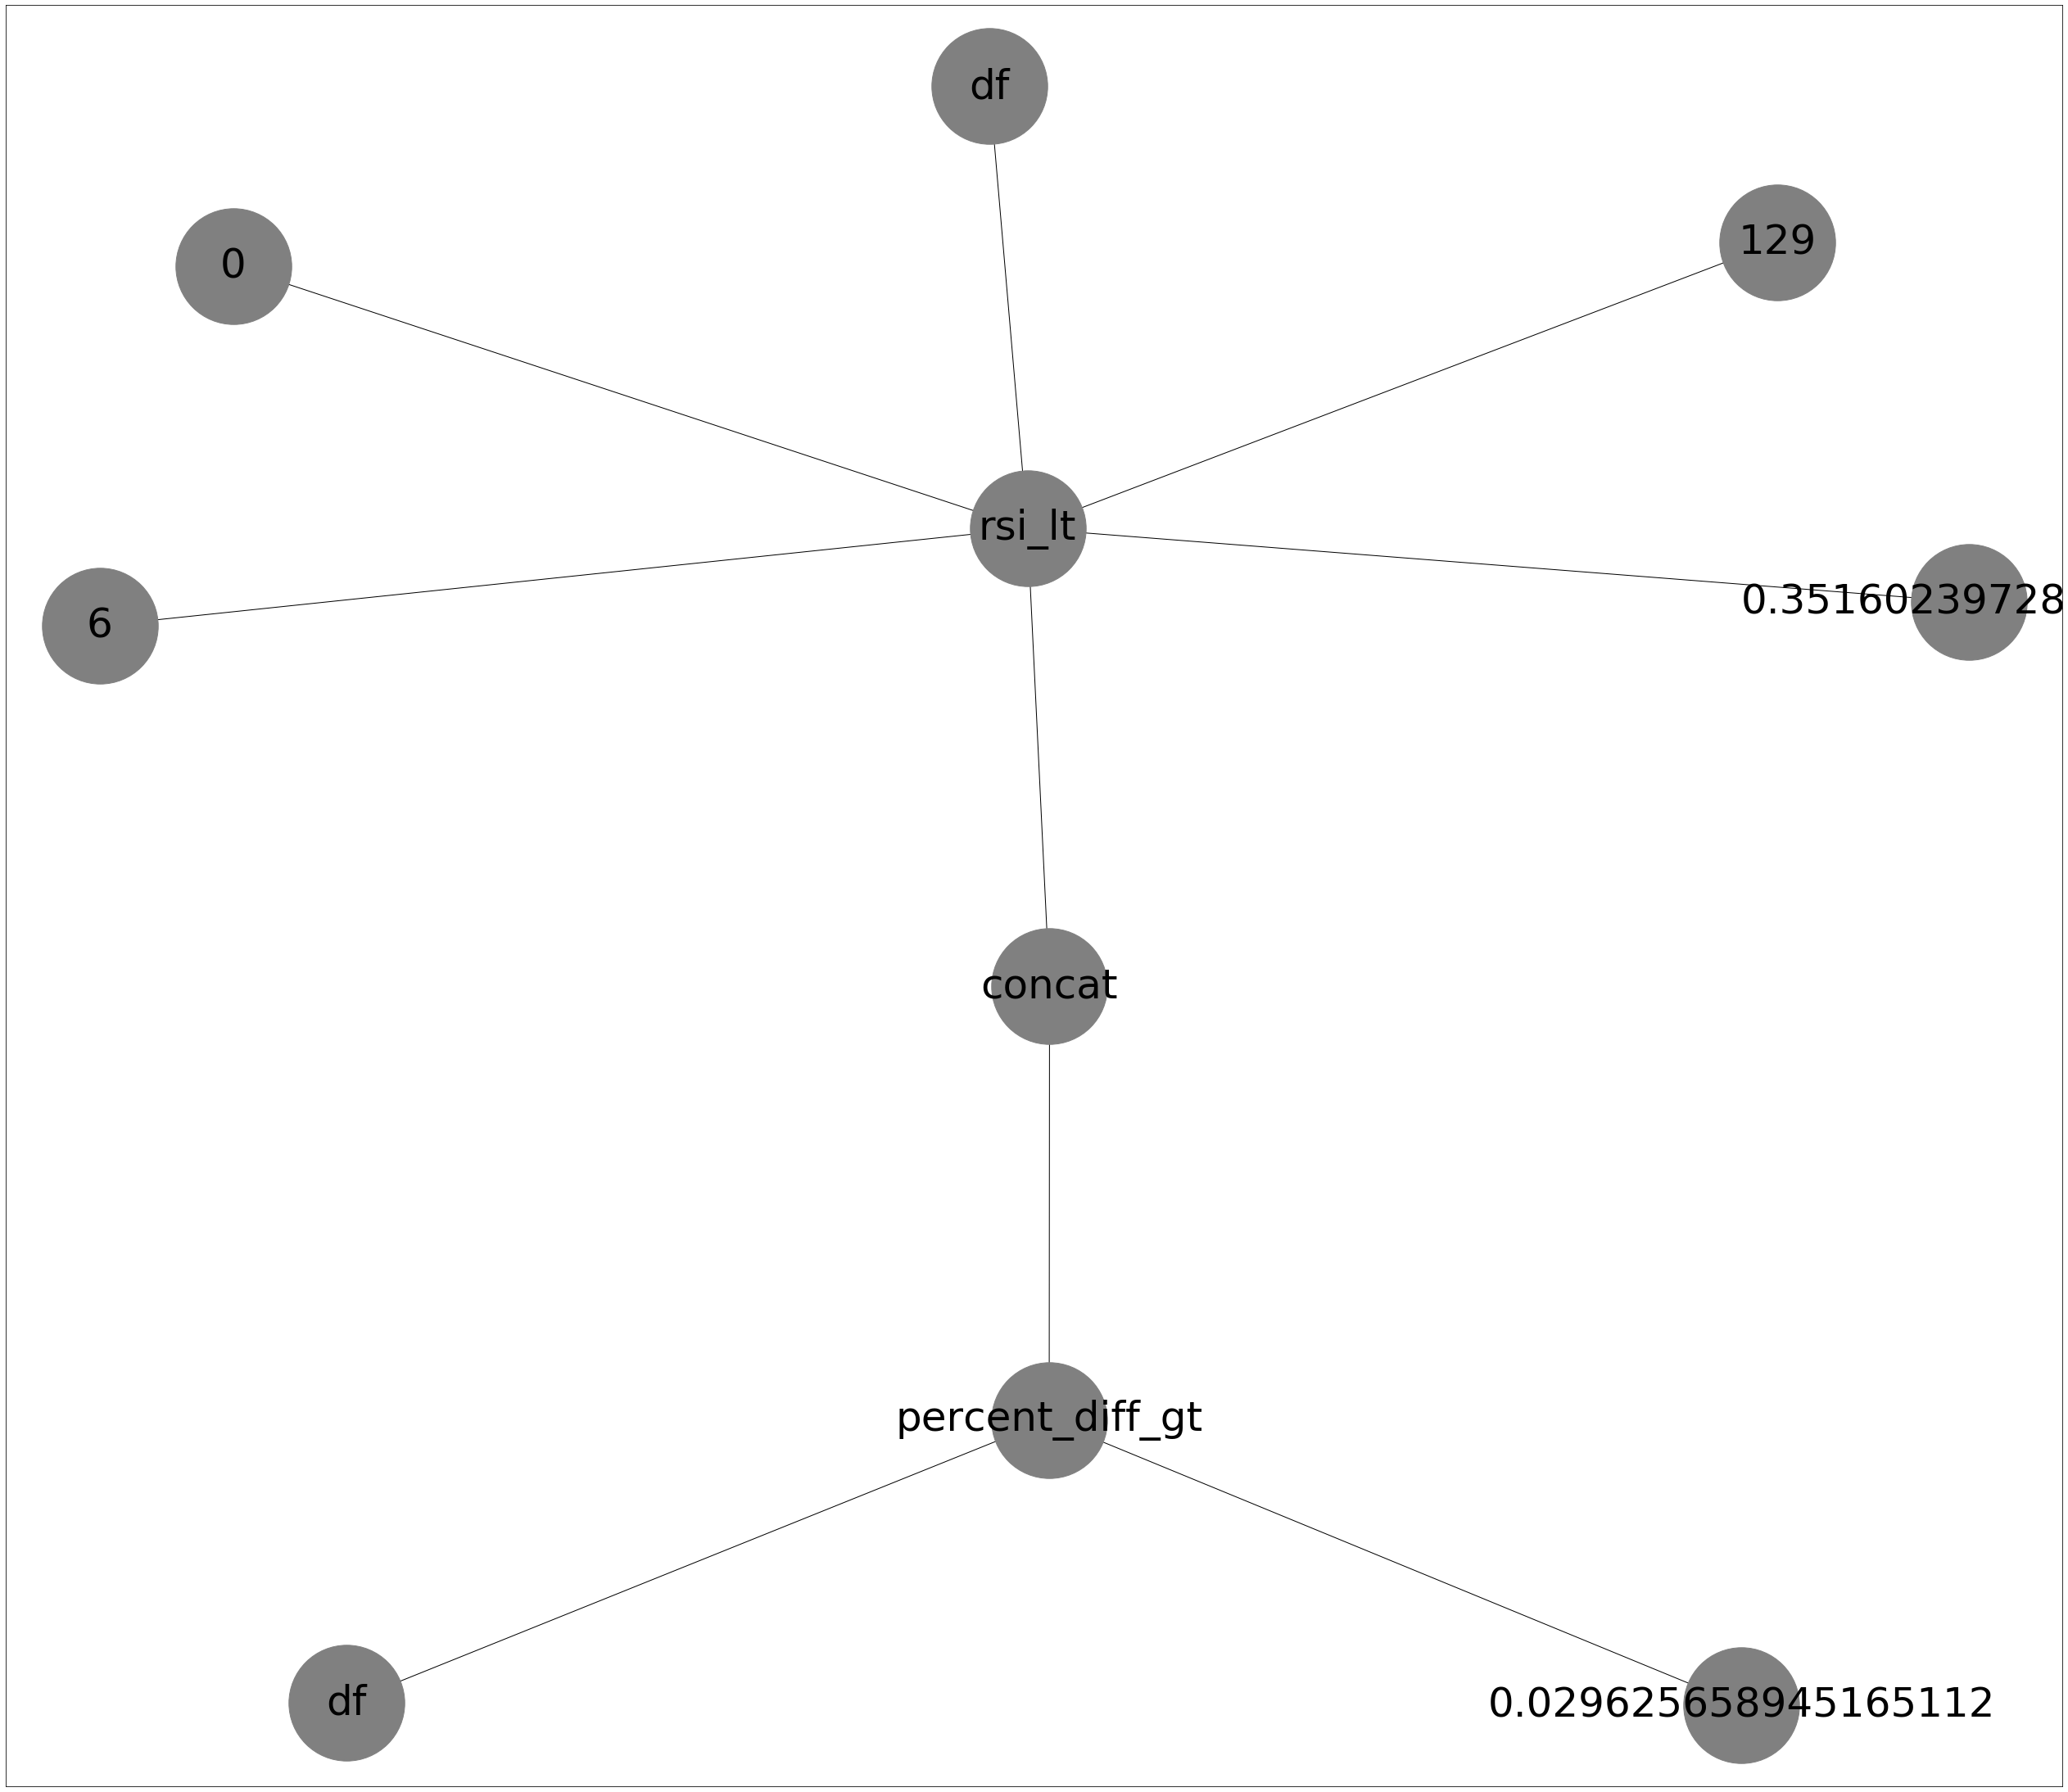

1  	1    	300   	Ephem	-24299.8	9.67508
1  	1    	0     	best_of_two	-23664.9	23.0919


In [ ]:
demichad.evolve(300, 100)

In [ ]:
history = demichad.chad.history
history

In [ ]:
demichad.plot()

In [ ]:
demichad.graph()